In [85]:
import os
import gc
import optuna
import numpy as np
from utils import *
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [86]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)
df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [87]:
def fix_location(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    df_.loc[df_['location'].astype(str).str.contains('Kahraman Maras'), 'location'] = 'Kahramanmaras, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Şanliurfa'), 'location'] = 'Sanliurfa, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('İçel'), 'location'] = 'Mersin, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Afyon'), 'location'] = 'Afyonkarahisar, Turkey'
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)
        df_['based_on_tr'] = df_['location'].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)

    return df_

df = fix_location(df)

skills_df = load_skills(config.skills_path, 30)
lang_df = load_languages(config.languages_path)
edu_df = load_education(config.education_path, 12)
exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 320842


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


(66274, 80)


,user_id,industry,location,moved_after_2019,based_on_tr,skill_Java,skill_JavaScript,skill_C#,skill_SQL,skill_Software Development,...,degree_Bachelor of Engineering,degree_Doctor of Philosophy,degree_Master of Business Administration,degree_Mühendislik Fakültesi Mezunu,total_experience,last_experience,nunique_company,avg_days_to_quit,last_start_year,last_start_month
0,1301,Information Technology and Services,ISTANBUL,1.0,1,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1341.0,306.0,3.0,447.000000,2018.0,3.0
1,6950,Internet,ISTANBUL,0.0,1,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,2101.0,699.0,4.0,525.250000,2017.0,2.0
2,4880,Online Media,TURKEY,0.0,1,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1826.0,610.0,4.0,456.500000,2017.0,5.0
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3409.0,1553.0,1.0,3409.000000,2014.0,10.0
4,11005,Banking,ISTANBUL,0.0,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3409.0,640.0,3.0,1136.333333,2017.0,4.0


In [88]:
target = 'moved_after_2019'
cat_features = ['industry', 'location']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 79)
test_set: (13255, 79)


Learning rate set to 0.039078
0:	learn: 0.6505382	test: 0.6505382	test1: 0.6373444	best: 0.6373444 (0)	total: 141ms	remaining: 11m 43s
200:	learn: 0.8602505	test: 0.8602505	test1: 0.7260656	best: 0.7268201 (192)	total: 17.8s	remaining: 7m 5s
400:	learn: 0.9082839	test: 0.9082839	test1: 0.7441720	best: 0.7443229 (394)	total: 37.9s	remaining: 7m 14s
600:	learn: 0.9360980	test: 0.9360980	test1: 0.7523199	best: 0.7529234 (589)	total: 56.6s	remaining: 6m 54s
800:	learn: 0.9534001	test: 0.9534001	test1: 0.7560920	best: 0.7567710 (770)	total: 1m 14s	remaining: 6m 30s
1000:	learn: 0.9657982	test: 0.9657982	test1: 0.7597133	best: 0.7601660 (961)	total: 1m 32s	remaining: 6m 10s
1200:	learn: 0.9738457	test: 0.9738457	test1: 0.7611467	best: 0.7625802 (1166)	total: 1m 50s	remaining: 5m 50s
1400:	learn: 0.9794286	test: 0.9794286	test1: 0.7638627	best: 0.7643154 (1394)	total: 2m 8s	remaining: 5m 31s
1600:	learn: 0.9838296	test: 0.9838296	test1: 0.7623538	best: 0.7643154 (1394)	total: 2m 26s	remaining

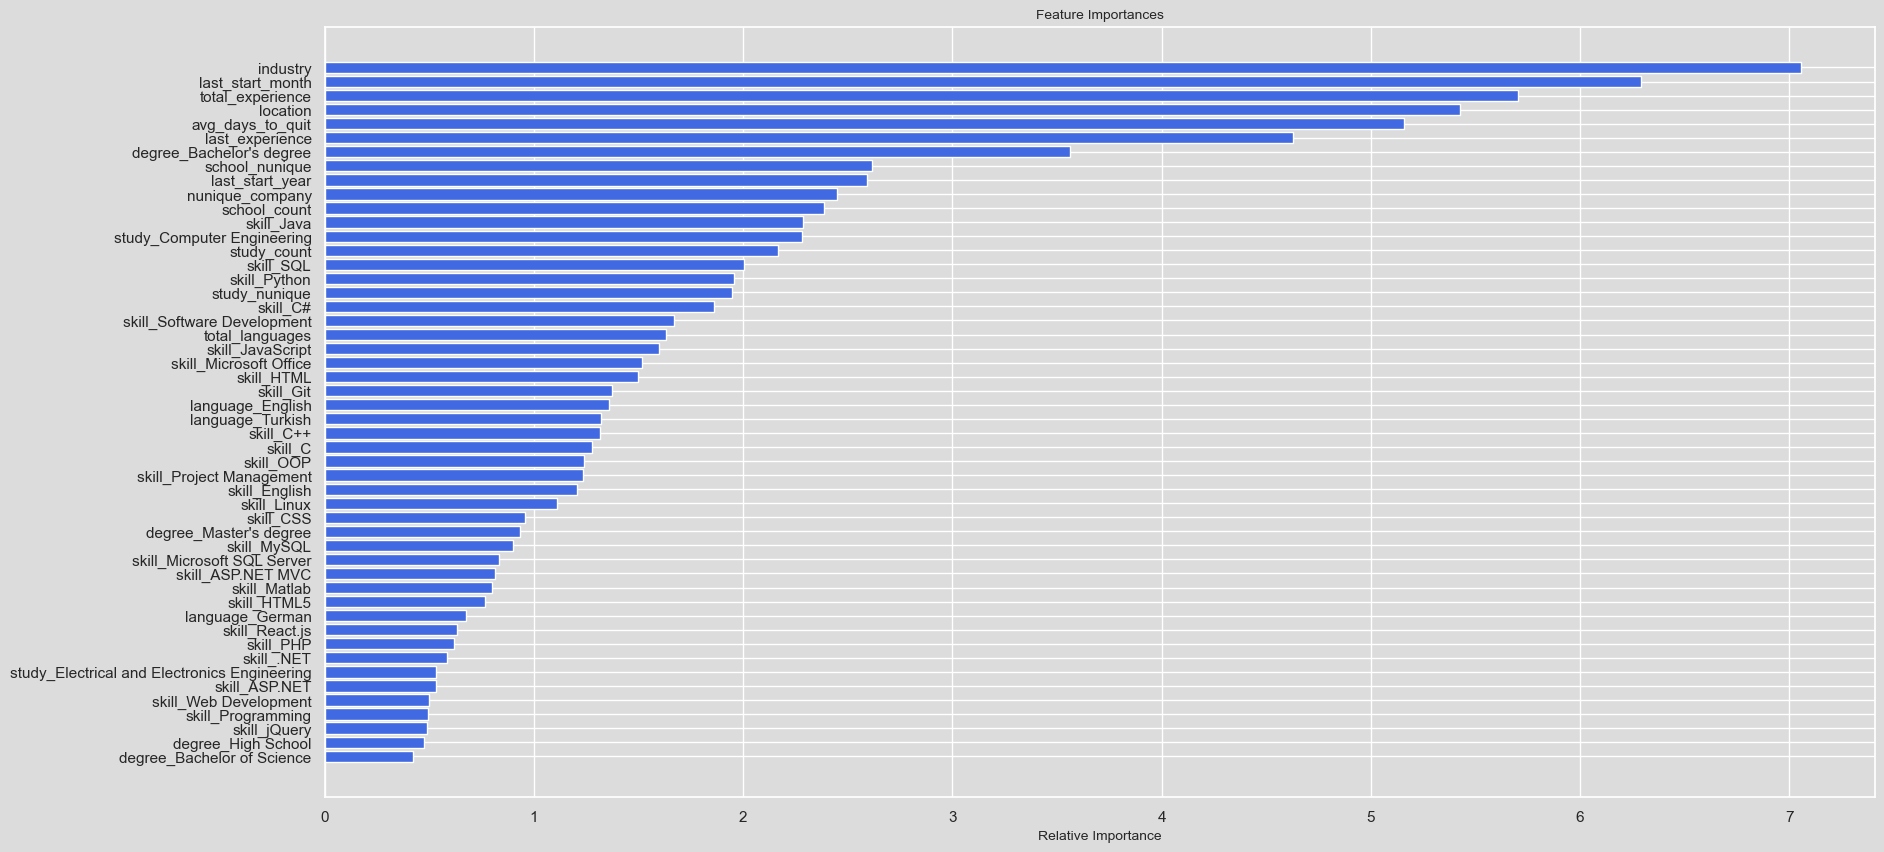

In [89]:
X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

params = {'one_hot_max_size': 179, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

params['verbose'] = False
params['random_state'] = config.seed
params['cat_features'] = cat_features
params['eval_metric'] = 'Accuracy'
params['allow_writing_files'] = False
params["iterations"] = 5000

model = CatBoostClassifier(**params)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=400,
    verbose=200,
)

y_pred = model.predict(X_test)
val_score = accuracy_score(y_test, y_pred)
print(f"Accuracy: {val_score}")
print(f"F1 Score: {f1_score(y_test, y_pred)}", "\n")
plot_importances(model, features)

Accuracy: 0.7671067521689928

In [37]:
params = {'max_depth': 12,
          'subsample': 0.9,
          'learning_rate': 0.01,
          'max_cat_to_onehot': 150}

#params['eval_metric'] = 'accuracy'
params['random_state'] = config.seed
params['tree_method'] = 'hist'
params['n_estimators'] = 5000
params['enable_categorical'] = True
params['objective'] = "binary:logistic"

model = XGBClassifier(**params)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=400,
    verbose=200,
)

y_pred = model.predict(X_test)
val_score = accuracy_score(y_test, y_pred)
print(f"Accuracy: {val_score}")
print(f"F1 Score: {f1_score(y_test, y_pred)}", "\n")

[0]	validation_0-logloss:0.69048	validation_1-logloss:0.69126
[100]	validation_0-logloss:0.53143	validation_1-logloss:0.59173
[200]	validation_0-logloss:0.46361	validation_1-logloss:0.55902
[300]	validation_0-logloss:0.42901	validation_1-logloss:0.54414
[400]	validation_0-logloss:0.41040	validation_1-logloss:0.53711
[500]	validation_0-logloss:0.39822	validation_1-logloss:0.53266
[600]	validation_0-logloss:0.38845	validation_1-logloss:0.52944
[700]	validation_0-logloss:0.38098	validation_1-logloss:0.52685
[800]	validation_0-logloss:0.37374	validation_1-logloss:0.52442
[900]	validation_0-logloss:0.36589	validation_1-logloss:0.52175
[1000]	validation_0-logloss:0.35845	validation_1-logloss:0.51947
[1100]	validation_0-logloss:0.35081	validation_1-logloss:0.51703
[1200]	validation_0-logloss:0.34325	validation_1-logloss:0.51456
[1300]	validation_0-logloss:0.33440	validation_1-logloss:0.51191
[1400]	validation_0-logloss:0.32766	validation_1-logloss:0.50978
[1500]	validation_0-logloss:0.32055	v

Accuracy: 0.7622029422859299

In [10]:
#sub[target] = base_cat.predict(test_set.drop(columns=[target], axis=1)).astype(int)

##sub.head()

In [11]:
#sub.tail()

In [12]:
#sub.to_csv(f'../submissions/submission_{round(val_score, 6)}.csv', index = False)